<font size='10'><h1 align="center"><font color='blue'>iPy oxDNA Examples</font></h1>

<center>
<img src="oxDNA.png">
</center>

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Duplex Melting</font></h2> 

In [188]:
from umbrella_sampling import ComUmbrellaSampling, MeltingUmbrellaSampling
from oxdna_simulation import SimulationManager, Simulation, Observable
from wham_analysis import collect_coms
import os
import matplotlib.pyplot as plt
from vmmc import *
from collections import Counter
from parameter_search import * 
import numpy as np
from skopt import Optimizer
from skopt.space import Categorical, Space
from scipy.special import logsumexp
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
path = os.path.abspath('/scratch/mlsample/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/')

system_name = 'multi_system_runs'

k_value_list = ['5_normal_1']#, '5_unique_1']
# k_value_list = ['5']

systems = [f'duplex_52_{stiff}' for stiff in k_value_list]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]


com_list = '8,9,10,11,12,13,14,15'
ref_list = '0,1,2,3,4,5,6,7'
xmin = 0
xmax = 10
n_windows = 100
starting_r0 = 1
steps = 1e6



pre_equlibration_parameters_list = [{'backend':'CPU','steps':'1e6','print_energy_every': '4e7',
                           'print_conf_interval':'4e7', "CUDA_list": "no",
                           'use_edge': 'false', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                           'T':f'52C'} for _ in k_value_list]

equlibration_parameters_list = [{'backend':'CPU','steps':'1e7','print_energy_every': '4e7',
                           'print_conf_interval':'4e7', "CUDA_list": "no",
                           'use_edge': 'false', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                           'T':f'52C'} for _ in k_value_list]

production_parameters_list = [{'backend':'CPU','steps':'1e7','print_energy_every': '1e8',
                        'print_conf_interval':'1e8', "CUDA_list": "no",
                        'use_edge': 'false', 'refresh_vel': '1',
                        'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                        'T':f'52C'} for temp in k_value_list]

us_list = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]

simulation_manager = SimulationManager()

In [23]:
for us, pre_equlibration_parameters, stiff in zip(us_list, pre_equlibration_parameters_list, k_value_list):
    print(us.system)
    us.build_pre_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, pre_equlibration_parameters, starting_r0, steps,
                               print_every=1000, observable=True, protein=None,
                               force_file=None, continue_run=False)

duplex_52_1


In [24]:
simulation_manager.worker_manager(cpu_run=True, gpu_mem_block=False)

Running: 0
Running: 1
Running: 2
Running: 3
Running: 4
Running: 5
Running: 6
Running: 7
Running: 8
Running: 9
Running: 10
Running: 11
Running: 12
Running: 13
Running: 14
Running: 15
Running: 16
Running: 17
Running: 18
Running: 19
Running: 20
Running: 21
Running: 22
Running: 23
Running: 24
Running: 25
Running: 26
Running: 27
Running: 28
Running: 29
Running: 30
Running: 31
Running: 32
Running: 33
Running: 34
Running: 35
Running: 36
Running: 37
Running: 38
Running: 39
Running: 40
Running: 41
Running: 42
Running: 43
Running: 44
Running: 45
Running: 46
Running: 47
Running: 48
Running: 49
Running: 50
Running: 51
Running: 52
Running: 53
Running: 54
Running: 55
Running: 56
Running: 57
Running: 58
Running: 59
Running: 60
Running: 61
Running: 62
Running: 63
Running: 64
Running: 65
Running: 66
Running: 67
Running: 68
Running: 69
Running: 70
Running: 71
Running: 72
Running: 73
Running: 74
Running: 75
Running: 76
Running: 77
Running: 78
Running: 79
Running: 80
Running: 81
Running: 82
Running: 83
Ru

INFO: Lists updated 2417 times (every ~413.736036 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.099 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00074 MB/s



Run time: 25.040903422050178
Finished: 18


INFO: Lists updated 3024 times (every ~330.687831 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.105 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000779 MB/s



Run time: 26.135933374986053
Finished: 13
Run time: 26.68979194900021
Finished: 9


INFO: Lists updated 2844 times (every ~351.617440 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.108 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000745 MB/s

INFO: Lists updated 2254 times (every ~443.655723 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.103 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00073 MB/s



Run time: 27.15618897904642
Finished: 6


INFO: Lists updated 1945 times (every ~514.138817 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.097 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000718 MB/s



Run time: 27.837787901982665
Finished: 3
Run time: 28.185216529062018
Finished: 1
Run time: 28.083266502944753
Finished: 2


INFO: Lists updated 2346 times (every ~426.257460 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.113 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000699 MB/s

INFO: Lists updated 1936 times (every ~516.528926 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.078 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000689 MB/s

INFO: Lists updated 2089 times (every ~478.697942 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.106 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000693 MB/s



Run time: 27.84968688711524
Finished: 5


INFO: Lists updated 2245 times (every ~445.434298 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.058 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000697 MB/s



Run time: 28.17990260082297
Finished: 4
Run time: 24.354282689047977
Finished: 38
Run time: 27.549989871913567
Finished: 11
Run time: 28.015787614975125
Finished: 7


INFO: Lists updated 2170 times (every ~460.829493 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.084 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00069 MB/s

INFO: Lists updated 3033 times (every ~329.706561 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.071 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000801 MB/s

INFO: Lists updated 2547 times (every ~392.618767 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.075 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000706 MB/s

INFO: Lists updated 2067 times (every ~483.792937 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.074 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000694 MB/s



Run time: 28.01718212594278
Finished: 8
Run time: 27.99820668110624
Finished: 10


INFO: Lists updated 2153 times (every ~464.468184 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.151 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000697 MB/s

INFO: Lists updated 1976 times (every ~506.072874 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.104 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000695 MB/s



Run time: 27.77888774801977
Finished: 14
Run time: 26.29354678094387
Finished: 28
Run time: 27.363676724024117
Finished: 19
Run time: 28.178372235037386
Finished: 12


INFO: Lists updated 2103 times (every ~475.511175 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.085 KB written to files
	 62.000  B written to stdout/stderr
	For a total of   0.0007 MB/s

INFO: Lists updated 2817 times (every ~354.987575 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.082 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000742 MB/s

INFO: Lists updated 2866 times (every ~348.918353 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.093 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000713 MB/s

INFO: Lists updated 1983 times (every ~504.286435 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.094 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00069 MB/s



Run time: 22.02572742011398
Finished: 66
Run time: 28.171407434158027
Finished: 15
Run time: 28.1934066421818
Finished: 16


INFO: Lists updated 3216 times (every ~310.945274 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.086 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000892 MB/s

INFO: Lists updated 1888 times (every ~529.661017 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.072 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00069 MB/s

INFO: Lists updated 1816 times (every ~550.660793 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.090 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00069 MB/s



Run time: 23.777072324883193
Finished: 54
Run time: 27.708522126078606
Finished: 21
Run time: 27.27926311804913
Finished: 25
Run time: 22.4497471798677
Run time: 25.511460280045867Finished: 65

Finished: 40
Run time: 28.22904642787762
Finished: 17
Run time: 27.141252354951575
Finished: 27
Run time: 26.894658839097247
Finished: 29
Run time: 27.983617380959913
Finished: 20


INFO: Lists updated 2707 times (every ~369.412634 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.088 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000702 MB/s

INFO: Lists updated 3086 times (every ~324.044070 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.080 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000823 MB/s

INFO: Lists updated 3064 times (every ~326.370757 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.074 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000876 MB/s

INFO: Lists updated 1874 times (every ~533.617930 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.117 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000689 MB/s

INFO: Lists updated 3205 times (every ~312.012480 steps)
INFO: Aggregated I/O statistics (set de

Run time: 26.77369647892192
Finished: 31
Run time: 21.308135034982115
Finished: 76
Run time: 25.53521857317537
Finished: 42


INFO: Lists updated 2200 times (every ~454.545455 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.076 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000725 MB/s

INFO: Lists updated 3286 times (every ~304.321363 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.089 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000926 MB/s

INFO: Lists updated 2584 times (every ~386.996904 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.078 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000764 MB/s



Run time: 28.045949255116284
Finished: 22
Run time: 27.20848995889537
Finished: 30
Run time: 28.08791784499772
Finished: 23
Run time: 26.55990658700466
Finished: 36


INFO: Lists updated 2007 times (every ~498.256104 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.096 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000694 MB/s

INFO: Lists updated 2527 times (every ~395.726157 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.057 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000714 MB/s

INFO: Lists updated 2770 times (every ~361.010830 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.101 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000736 MB/s

INFO: Lists updated 2127 times (every ~470.145745 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.108 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000695 MB/s



Run time: 23.936579100089148
Finished: 58
Run time: 26.06103170593269
Finished: 41
Run time: 28.14438217994757
Finished: 24
Run time: 22.01379099395126
Finished: 75


INFO: Lists updated 2896 times (every ~345.303867 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.065 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000815 MB/s

INFO: Lists updated 2963 times (every ~337.495781 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.076 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000747 MB/s

INFO: Lists updated 2036 times (every ~491.159136 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.074 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00069 MB/s

INFO: Lists updated 3019 times (every ~331.235508 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.073 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000893 MB/s



Run time: 25.28397914604284
Finished: 49
Run time: 27.194666447117925
Finished: 33
Run time: 27.455309740034863
Finished: 32
Run time: 18.880746006965637
Finished: 101


INFO: Lists updated 2586 times (every ~386.697602 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.092 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000717 MB/s

INFO: Lists updated 2800 times (every ~357.142857 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.072 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000772 MB/s

INFO: Lists updated 2748 times (every ~363.901019 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.093 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000709 MB/s

INFO: Lists updated 3637 times (every ~274.951883 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.065 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00105 MB/s



Run time: 28.231088775908574
Finished: 26
Run time: 22.910877449903637
Finished: 70
Run time: 25.17742408416234
Finished: 52
Run time: 20.72831079806201
Finished: 88
Run time: 24.073819244047627
Finished: 61
Run time: 20.7230786238797
Finished: 89
Run time: 20.48727376596071
Finished: 91


INFO: Lists updated 2172 times (every ~460.405157 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.085 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00069 MB/s

INFO: Lists updated 2925 times (every ~341.880342 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.059 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000855 MB/s

INFO: Lists updated 2664 times (every ~375.375375 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.089 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000774 MB/s

INFO: Lists updated 3200 times (every ~312.500000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.096 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000954 MB/s

INFO: Lists updated 2902 times (every ~344.589938 steps)
INFO: Aggregated I/O statistics (set de

Run time: 24.9928935370408
Finished: 55
Run time: 26.23357040504925
Finished: 45
Run time: 24.832154035102576
Finished: 57
Run time: 21.876521094003692
Finished: 81


INFO: Lists updated 3259 times (every ~306.842590 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.077 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000783 MB/s

INFO: Lists updated 2482 times (every ~402.900886 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.087 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000743 MB/s

INFO: Lists updated 2478 times (every ~403.551251 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.109 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000786 MB/s

INFO: Lists updated 3017 times (every ~331.455088 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.082 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000902 MB/s



Run time: 27.741214361041784
Finished: 34
Run time: 27.690606953809038
Finished: 35
Run time: 25.807713109999895
Finished: 51
Run time: 23.735093154013157
Finished: 68
Run time: 18.188852122984827
Finished: 111
Run time: 24.757998978951946
Finished: 60


INFO: Lists updated 2308 times (every ~433.275563 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.088 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000701 MB/s

INFO: Lists updated 2482 times (every ~402.900886 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.095 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000704 MB/s

INFO: Lists updated 2913 times (every ~343.288706 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.104 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000756 MB/s

INFO: Lists updated 3054 times (every ~327.439424 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.079 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000825 MB/s

INFO: Lists updated 3714 times (every ~269.251481 steps)
INFO: Aggregated I/O statistics (set de

Run time: 18.644064541207626
Finished: 108
Run time: 26.085497098974884
Finished: 50
Run time: 26.442889231955633
Finished: 48
Run time: 23.852326455991715
Finished: 69
Run time: 22.519885445944965
Finished: 80


INFO: Lists updated 3167 times (every ~315.756236 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.085 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00106 MB/s

INFO: Lists updated 2665 times (every ~375.234522 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.074 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000747 MB/s

INFO: Lists updated 2680 times (every ~373.134328 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.095 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000737 MB/s

INFO: Lists updated 3086 times (every ~324.044070 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.066 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000872 MB/s



Run time: 24.66547896596603
Finished: 63
Run time: 23.577007029904053
Finished: 72
Run time: 22.97616543993354
Finished: 77
Run time: 22.736962024122477
Finished: 79
Run time: 26.888307390967384
Finished: 46


INFO: Lists updated 2876 times (every ~347.705146 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.090 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00082 MB/s

INFO: Lists updated 2937 times (every ~340.483487 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.057 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000789 MB/s

INFO: Lists updated 2780 times (every ~359.712230 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.088 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000831 MB/s

INFO: Lists updated 2935 times (every ~340.715503 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.104 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000856 MB/s

INFO: Lists updated 2879 times (every ~347.342827 steps)
INFO: Aggregated I/O statistics (set de

Run time: 22.51085385098122
Finished: 82
Run time: 26.162929574027658
Finished: 53
Run time: 28.08972014207393
Finished: 37
Run time: 20.933232011040673
Finished: 95
Run time: 21.132999836932868
Finished: 94
Run time: 21.418566912878305
Finished: 92
Run time: 22.18791963206604
Finished: 86


INFO: Lists updated 3203 times (every ~312.207306 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.090 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000875 MB/s

INFO: Lists updated 2777 times (every ~360.100828 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.063 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000744 MB/s

INFO: Lists updated 1945 times (every ~514.138817 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.074 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000692 MB/s

INFO: Lists updated 3338 times (every ~299.580587 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.066 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000938 MB/s

INFO: Lists updated 3033 times (every ~329.706561 steps)
INFO: Aggregated I/O statistics (set de

Run time: 21.391695347847417
Finished: 93
Run time: 21.78906000009738
Finished: 90
Run time: 28.095237070927396
Finished: 39
Run time: 24.671794205904007
Finished: 67
Run time: 22.70643168198876
Finished: 83
Run time: 25.359108852921054
Finished: 62


INFO: Lists updated 3103 times (every ~322.268772 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.101 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000919 MB/s

INFO: Lists updated 3270 times (every ~305.810398 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.090 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00092 MB/s

INFO: Lists updated 2852 times (every ~350.631136 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.066 KB written to files
	 62.000  B written to stdout/stderr
	For a total of   0.0009 MB/s

INFO: Lists updated 2066 times (every ~484.027106 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.059 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000692 MB/s

INFO: Lists updated 3006 times (every ~332.667997 steps)
INFO: Aggregated I/O statistics (set de

Run time: 27.281154782976955
Finished: 47
Run time: 25.81831171992235
Finished: 59
Run time: 22.751045042881742
Finished: 85


INFO: Lists updated 2394 times (every ~417.710944 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.060 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000712 MB/s

INFO: Lists updated 2417 times (every ~413.736036 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.129 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000756 MB/s

INFO: Lists updated 3391 times (every ~294.898260 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.043 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000861 MB/s



Run time: 20.970239746849984
Finished: 99
Run time: 22.97910136799328
Finished: 84
Run time: 28.04590528202243
Finished: 43
Run time: 25.521163267083466
Finished: 64


INFO: Lists updated 3371 times (every ~296.647879 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.067 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000937 MB/s

INFO: Lists updated 3021 times (every ~331.016220 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.092 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000855 MB/s

INFO: Lists updated 2133 times (every ~468.823254 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.096 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000695 MB/s

INFO: Lists updated 2811 times (every ~355.745286 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.092 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000768 MB/s



Run time: 24.53300298610702
Finished: 73
Run time: 24.845315602142364
Finished: 71
Run time: 28.19726851116866
Finished: 44
Run time: 21.493744069943205
Finished: 98


INFO: Lists updated 3099 times (every ~322.684737 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.098 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000799 MB/s

INFO: Lists updated 3026 times (every ~330.469266 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.108 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000789 MB/s

INFO: Lists updated 1878 times (every ~532.481363 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.086 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000689 MB/s

INFO: Lists updated 3523 times (every ~283.848992 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.091 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000917 MB/s



Run time: 24.827524724183604
Finished: 74


INFO: Lists updated 2545 times (every ~392.927308 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.097 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000789 MB/s



Run time: 20.834265019977465
Finished: 107
Run time: 21.832684813067317
Finished: 100
Run time: 21.643666840856895
Finished: 102


INFO: Lists updated 3384 times (every ~295.508274 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.075 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000946 MB/s

INFO: Lists updated 2974 times (every ~336.247478 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.077 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000899 MB/s

INFO: Lists updated 2838 times (every ~352.360817 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.082 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000911 MB/s



Run time: 23.830443867947906
Finished: 87
Run time: 20.22309285402298
Finished: 114
Run time: 21.435077444883063
Finished: 105
Run time: 19.998604736989364
Finished: 116Run time: 27.728535560891032

Finished: 56
Run time: 19.93173625599593
Finished: 117
Run time: 22.785905534168705
Finished: 96
Run time: 21.73465250991285
Finished: 104


INFO: Lists updated 2969 times (every ~336.813742 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.078 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000977 MB/s

INFO: Lists updated 2361 times (every ~423.549343 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.062 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000821 MB/s

INFO: Lists updated 3073 times (every ~325.414904 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.056 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000915 MB/s

INFO: Lists updated 3560 times (every ~280.898876 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.106 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000989 MB/s

INFO: Lists updated 2231 times (every ~448.229494 steps)
INFO: Aggregated I/O statistics (set de

Run time: 20.34473918005824
Finished: 115
Run time: 25.281206685118377
Finished: 78
Run time: 22.028572716983035
Finished: 103
Run time: 20.77571287099272
Finished: 113


INFO: Lists updated 3267 times (every ~306.091215 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.061 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00097 MB/s

INFO: Lists updated 2405 times (every ~415.800416 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.077 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000773 MB/s

INFO: Lists updated 2855 times (every ~350.262697 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.050 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000891 MB/s

INFO: Lists updated 3203 times (every ~312.207306 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.090 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000948 MB/s



Run time: 23.19258513301611
Finished: 97
Run time: 20.29024317394942
Finished: 119
Run time: 22.052419937914237
Finished: 106
Run time: 21.71712284302339
Finished: 109


INFO: Lists updated 2676 times (every ~373.692078 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.063 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000844 MB/s

INFO: Lists updated 3228 times (every ~309.789343 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.069 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000971 MB/s

INFO: Lists updated 3133 times (every ~319.182892 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.054 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000888 MB/s

INFO: Lists updated 2655 times (every ~376.647834 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.108 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000905 MB/s



Run time: 22.25957338605076
Run time: 21.19045259989798Finished: 110

Finished: 118


INFO: Lists updated 2910 times (every ~343.642612 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.089 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000928 MB/s

INFO: Lists updated 2679 times (every ~373.273610 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.086 KB written to files
	 62.000  B written to stdout/stderr
	For a total of 0.000886 MB/s



Run time: 23.027396290097386
Finished: 112


INFO: Lists updated 2703 times (every ~369.959304 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 19.094 KB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00085 MB/s



All queued simulations finished in: 37.86561700585298


In [25]:
for us, equlibration_parameters, stiff in zip(us_list, equlibration_parameters_list, k_value_list):
    print(us.system)
    us.build_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, equlibration_parameters,
                               print_every=1000, observable=True, protein=None,
                               force_file=None, continue_run=False)

duplex_52_1


In [ ]:
for us in us_list[1:]:
    us.modify_topology_for_unique_pairing()

In [26]:
simulation_manager.worker_manager(cpu_run=True, gpu_mem_block=False)

Running: 0
Running: 1
Running: 2
Running: 3
Running: 4
Running: 5
Running: 6
Running: 7
Running: 8
Running: 9
Running: 10
Running: 11
Running: 12
Running: 13
Running: 14
Running: 15
Running: 16
Running: 17
Running: 18
Running: 19
Running: 20
Running: 21
Running: 22
Running: 23
Running: 24
Running: 25
Running: 26
Running: 27
Running: 28
Running: 29
Running: 30
Running: 31
Running: 32
Running: 33
Running: 34
Running: 35
Running: 36
Running: 37
Running: 38
Running: 39
Running: 40
Running: 41
Running: 42
Running: 43
Running: 44
Running: 45
Running: 46
Running: 47
Running: 48
Running: 49
Running: 50
Running: 51
Running: 52
Running: 53
Running: 54
Running: 55
Running: 56
Running: 57
Running: 58
Running: 59
Running: 60
Running: 61
Running: 62
Running: 63
Running: 64
Running: 65
Running: 66
Running: 67
Running: 68
Running: 69
Running: 70
Running: 71
Running: 72
Running: 73
Running: 74
Running: 75
Running: 76
Running: 77
Running: 78
Running: 79
Running: 80
Running: 81
Running: 82
Running: 83
Ru

INFO: Lists updated 40006 times (every ~249.962506 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of   0.0078 MB/s



Run time: 140.3260361198336
Finished: 78
Run time: 139.71342065092176
Finished: 83


INFO: Lists updated 39705 times (every ~251.857449 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00777 MB/s

INFO: Lists updated 39767 times (every ~251.464782 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00781 MB/s



Run time: 141.27090765815228
Finished: 74
Run time: 139.95903372415341
Finished: 84


INFO: Lists updated 39385 times (every ~253.903770 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00772 MB/s

INFO: Lists updated 40485 times (every ~247.005064 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of   0.0078 MB/s



Run time: 140.14211403601803
Finished: 88
Run time: 139.59181267721578
Finished: 94


INFO: Lists updated 39408 times (every ~253.755583 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00778 MB/s

INFO: Lists updated 39449 times (every ~253.491850 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00782 MB/s



Run time: 142.99450249690562
Finished: 69
Run time: 139.6987106341403
Finished: 95


INFO: Lists updated 38612 times (every ~258.986843 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00762 MB/s

INFO: Lists updated 40391 times (every ~247.579906 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00782 MB/s



Run time: 141.53610151284374
Finished: 82
Run time: 143.17769795493223
Finished: 70
Run time: 142.64523324090987
Finished: 75


INFO: Lists updated 38971 times (every ~256.601062 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of   0.0077 MB/s

INFO: Lists updated 39621 times (every ~252.391409 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00761 MB/s

INFO: Lists updated 39524 times (every ~253.010829 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00765 MB/s



Run time: 144.685478878906
Finished: 61
Run time: 143.2377781169489
Finished: 72
Run time: 141.58254306111485
Finished: 85
Run time: 142.669814161025
Finished: 77
Run time: 144.581151986029
Finished: 63


INFO: Lists updated 39683 times (every ~251.997077 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00752 MB/s

INFO: Lists updated 38632 times (every ~258.852765 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00761 MB/s

INFO: Lists updated 37806 times (every ~264.508279 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00771 MB/s

INFO: Lists updated 38489 times (every ~259.814492 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00764 MB/s



Run time: 142.15035985899158
Finished: 81
Run time: 140.18833549902774
Finished: 96
Run time: 141.11345791909844
Finished: 90


INFO: Lists updated 38807 times (every ~257.685469 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00753 MB/s

INFO: Lists updated 39122 times (every ~255.610654 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00769 MB/s

INFO: Lists updated 39340 times (every ~254.194204 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00778 MB/s

INFO: Lists updated 37901 times (every ~263.845281 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00773 MB/s



Run time: 144.24526128382422
Finished: 68
Run time: 141.71840863209218
Finished: 87
Run time: 143.6148437259253
Finished: 73
Run time: 144.9236980350688
Finished: 64


INFO: Lists updated 39584 times (every ~252.627324 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00755 MB/s

INFO: Lists updated 39652 times (every ~252.194089 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00771 MB/s

INFO: Lists updated 38665 times (every ~258.631838 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00759 MB/s

INFO: Lists updated 39059 times (every ~256.022940 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00751 MB/s



Run time: 144.92358591407537
Finished: 66
Run time: 141.4672725778073
Finished: 92
Run time: 143.05954523500986
Finished: 80
Run time: 141.43327135196887
Finished: 93
Run time: 142.00095978099853
Finished: 89


INFO: Lists updated 39131 times (every ~255.551864 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00752 MB/s

INFO: Lists updated 40396 times (every ~247.549262 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00763 MB/s

INFO: Lists updated 38517 times (every ~259.625620 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00771 MB/s

INFO: Lists updated 38661 times (every ~258.658597 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00771 MB/s

INFO: Lists updated 39427 times (every ~253.633297 steps)
INFO: Aggregated I/O statistics (s

Run time: 141.00945234904066
Finished: 97


INFO: Lists updated 38217 times (every ~261.663658 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00773 MB/s



Run time: 141.25780141400173
Finished: 98


INFO: Lists updated 38744 times (every ~258.104481 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00772 MB/s



Run time: 140.56666507502086
Finished: 105
Run time: 142.5289258400444
Finished: 91
Run time: 140.55753451399505
Finished: 106
Run time: 141.4266651859507
Finished: 100


INFO: Lists updated 39106 times (every ~255.715236 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00776 MB/s

INFO: Lists updated 37881 times (every ~263.984583 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00765 MB/s

INFO: Lists updated 38937 times (every ~256.825128 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00776 MB/s



Run time: 145.90033868397586
Finished: 67
Run time: 141.21240184502676
Finished: 102


INFO: Lists updated 38353 times (every ~260.735796 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00772 MB/s

INFO: Lists updated 38011 times (every ~263.081739 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00746 MB/s

INFO: Lists updated 37978 times (every ~263.310338 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00772 MB/s



Run time: 146.38726235297509
Finished: 65
Run time: 145.70367976999842
Finished: 71


INFO: Lists updated 39407 times (every ~253.762022 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00744 MB/s

INFO: Lists updated 38086 times (every ~262.563672 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00749 MB/s



Run time: 143.86865173093975
Finished: 86
Run time: 141.49051883001812
Finished: 104
Run time: 140.85472436621785
Finished: 109
Run time: 144.91173258586787
Finished: 79
Run time: 141.71537093282677
Finished: 103


INFO: Lists updated 39616 times (every ~252.423263 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of   0.0076 MB/s

INFO: Lists updated 39465 times (every ~253.389079 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00772 MB/s

INFO: Lists updated 38298 times (every ~261.110241 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00774 MB/s

INFO: Lists updated 38229 times (every ~261.581522 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00752 MB/s

INFO: Lists updated 38935 times (every ~256.838320 steps)
INFO: Aggregated I/O statistics (s

Run time: 147.70370874088258
Finished: 60
Run time: 140.22740744589828
Finished: 117


INFO: Lists updated 40002 times (every ~249.987501 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00736 MB/s



Run time: 141.1254280069843
Finished: 111
Run time: 141.34690442495048
Finished: 110
Run time: 140.823238076875
Finished: 114


INFO: Lists updated 38874 times (every ~257.241344 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00778 MB/s

INFO: Lists updated 37899 times (every ~263.859205 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00773 MB/s

INFO: Lists updated 39042 times (every ~256.134419 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00772 MB/s



Run time: 142.5751017681323
Finished: 101
Run time: 147.97092805313878
Finished: 62
Run time: 141.2404205771163
Finished: 112


INFO: Lists updated 38998 times (every ~256.423406 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00775 MB/s

INFO: Lists updated 38908 times (every ~257.016552 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00766 MB/s

INFO: Lists updated 38362 times (every ~260.674626 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00737 MB/s

INFO: Lists updated 40896 times (every ~244.522692 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00773 MB/s



Run time: 143.09385271603242
Finished: 99


INFO: Lists updated 38599 times (every ~259.074069 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00764 MB/s



Run time: 142.21846609609202
Finished: 107
Run time: 142.101014705142
Finished: 108


INFO: Lists updated 38519 times (every ~259.612139 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00768 MB/s

INFO: Lists updated 39650 times (every ~252.206810 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00767 MB/s



Run time: 141.57969796308316
Finished: 116


INFO: Lists updated 38895 times (every ~257.102455 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00772 MB/s



Run time: 142.29506356199272
Finished: 113
Run time: 142.05224524182267
Finished: 115


INFO: Lists updated 39601 times (every ~252.518876 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00768 MB/s

INFO: Lists updated 40415 times (every ~247.432884 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00769 MB/s



Run time: 150.10782290506177
Finished: 57


INFO: Lists updated 38951 times (every ~256.732818 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00724 MB/s



Run time: 150.24194504902698
Finished: 59


INFO: Lists updated 39728 times (every ~251.711639 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00723 MB/s



Run time: 150.88959454395808
Finished: 58


INFO: Lists updated 38803 times (every ~257.712033 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00719 MB/s



Run time: 143.6444003279321
Finished: 119
Run time: 152.57285306998529
Finished: 53
Run time: 152.52774518891238
Finished: 54


INFO: Lists updated 38653 times (every ~258.712131 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00759 MB/s

INFO: Lists updated 39407 times (every ~253.762022 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00711 MB/s

INFO: Lists updated 38667 times (every ~258.618460 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00712 MB/s



Run time: 144.22458985098638
Finished: 118
Run time: 152.5970584251918
Finished: 56


INFO: Lists updated 38960 times (every ~256.673511 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00758 MB/s

INFO: Lists updated 38297 times (every ~261.117059 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00712 MB/s



Run time: 154.20263926498592
Finished: 50


INFO: Lists updated 39171 times (every ~255.290904 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00703 MB/s



Run time: 155.68123351107351
Finished: 48


INFO: Lists updated 39783 times (every ~251.363648 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00696 MB/s



Run time: 155.42958887200803
Finished: 52


INFO: Lists updated 37984 times (every ~263.268745 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00699 MB/s



Run time: 155.88430960592814
Finished: 51


INFO: Lists updated 39511 times (every ~253.094075 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00695 MB/s



Run time: 159.3279084940441
Finished: 49


INFO: Lists updated 38422 times (every ~260.267555 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00681 MB/s



Run time: 159.9139377339743
Finished: 47


INFO: Lists updated 39830 times (every ~251.067035 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00678 MB/s



Run time: 161.83042231202126
Finished: 45


INFO: Lists updated 38859 times (every ~257.340642 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of   0.0067 MB/s



Run time: 162.77547295601107
Finished: 46


INFO: Lists updated 38443 times (every ~260.125380 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00665 MB/s



Run time: 162.54444653983228
Finished: 55


INFO: Lists updated 38526 times (every ~259.564969 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00667 MB/s



Run time: 169.05948828486726
Finished: 44


INFO: Lists updated 38589 times (every ~259.141206 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00639 MB/s



Run time: 170.2176727980841
Finished: 42


INFO: Lists updated 39164 times (every ~255.336534 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00636 MB/s



Run time: 173.76609908998944
Finished: 38


INFO: Lists updated 37744 times (every ~264.942772 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00619 MB/s



Run time: 176.71299254498444
Finished: 43


INFO: Lists updated 37723 times (every ~265.090263 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of   0.0061 MB/s



Run time: 179.5754281100817
Finished: 40


INFO: Lists updated 37503 times (every ~266.645335 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00602 MB/s



Run time: 179.829726126045
Finished: 41


INFO: Lists updated 38784 times (every ~257.838284 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00607 MB/s



Run time: 182.97403675690293
Finished: 37
Run time: 183.34431634214707
Finished: 35


INFO: Lists updated 37871 times (every ~264.054290 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00586 MB/s

INFO: Lists updated 38181 times (every ~261.910374 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00585 MB/s



Run time: 184.50267504784279
Finished: 36


INFO: Lists updated 36586 times (every ~273.328596 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00584 MB/s



Run time: 184.67230589012615
Finished: 39


INFO: Lists updated 37646 times (every ~265.632471 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00582 MB/s



Run time: 190.4707352479454
Finished: 33


INFO: Lists updated 38363 times (every ~260.667831 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00564 MB/s



Run time: 191.0110810319893
Finished: 34


INFO: Lists updated 37806 times (every ~264.508279 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00561 MB/s



Run time: 197.2050740539562
Finished: 32


INFO: Lists updated 36656 times (every ~272.806635 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00542 MB/s



Run time: 199.9862441709265
Finished: 31


INFO: Lists updated 37531 times (every ~266.446404 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00534 MB/s



Run time: 202.4020799198188
Finished: 29


INFO: Lists updated 37059 times (every ~269.839985 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00528 MB/s



Run time: 212.44507258408703
Finished: 27


INFO: Lists updated 35179 times (every ~284.260496 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00501 MB/s



Run time: 228.08662673993967
Finished: 30


INFO: Lists updated 33919 times (every ~294.820012 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00466 MB/s



Run time: 234.23002838506363
Finished: 25


INFO: Lists updated 32533 times (every ~307.380199 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00453 MB/s



Run time: 238.15541745419614
Finished: 22


INFO: Lists updated 32303 times (every ~309.568771 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00445 MB/s



Run time: 238.77407672000118
Finished: 24


INFO: Lists updated 32553 times (every ~307.191349 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00444 MB/s



Run time: 240.44107707310468
Finished: 26


INFO: Lists updated 30846 times (every ~324.191143 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00441 MB/s



Run time: 241.43380004516803
Finished: 28


INFO: Lists updated 31438 times (every ~318.086392 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00439 MB/s



Run time: 253.83375105890445
Finished: 19


INFO: Lists updated 29444 times (every ~339.627768 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00417 MB/s



Run time: 255.25130222993903
Finished: 20


INFO: Lists updated 28504 times (every ~350.827954 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00414 MB/s



Run time: 255.66452411282808
Finished: 23


INFO: Lists updated 28139 times (every ~355.378656 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00413 MB/s



Run time: 259.16209988389164
Finished: 15


INFO: Lists updated 25722 times (every ~388.772257 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00407 MB/s



Run time: 259.28699614596553
Finished: 21


INFO: Lists updated 26281 times (every ~380.503025 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00408 MB/s



Run time: 260.3352117789909
Finished: 18


INFO: Lists updated 25732 times (every ~388.621172 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00407 MB/s



Run time: 261.9519780399278
Finished: 10


INFO: Lists updated 23753 times (every ~420.999453 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00403 MB/s



Run time: 264.3602850700263
Finished: 3
Run time: 264.32106742891483
Finished: 5


INFO: Lists updated 23268 times (every ~429.774798 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00399 MB/s

INFO: Lists updated 22355 times (every ~447.327220 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00399 MB/s



Run time: 265.4792559251655
Finished: 7


INFO: Lists updated 24892 times (every ~401.735497 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00398 MB/s



Run time: 265.26897059800103
Finished: 17
Run time: 266.01105419313535
Finished: 12


INFO: Lists updated 25235 times (every ~396.275015 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00398 MB/s

INFO: Lists updated 22379 times (every ~446.847491 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00397 MB/s



Run time: 267.1422375650145
Finished: 9


INFO: Lists updated 23128 times (every ~432.376340 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00395 MB/s



Run time: 268.01004242291674
Finished: 8
Run time: 267.1263666630257
Finished: 16
Run time: 269.11133820191026
Finished: 0


INFO: Lists updated 22306 times (every ~448.309872 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00394 MB/s

INFO: Lists updated 22588 times (every ~442.712945 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00395 MB/s

INFO: Lists updated 22309 times (every ~448.249585 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00392 MB/s



Run time: 267.92623157799244
Finished: 11
Run time: 268.9028729079291
Finished: 4


INFO: Lists updated 22466 times (every ~445.117066 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00394 MB/s

INFO: Lists updated 21713 times (every ~460.553585 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00392 MB/s



Run time: 269.20302270306274
Finished: 2
Run time: 267.96646509692073
Finished: 13
Run time: 267.8531599880662
Finished: 14


INFO: Lists updated 21152 times (every ~472.768533 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00392 MB/s

INFO: Lists updated 24732 times (every ~404.334465 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00394 MB/s

INFO: Lists updated 21941 times (every ~455.767741 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00394 MB/s



Run time: 269.04550647898577
Finished: 6
Run time: 269.7786271581426
Finished: 1


INFO: Lists updated 22414 times (every ~446.149728 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00392 MB/s

INFO: Lists updated 22555 times (every ~443.360674 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  1.015 MB written to files
	 62.000  B written to stdout/stderr
	For a total of  0.00392 MB/s



All queued simulations finished in: 270.24065212905407


In [30]:
for us, production_parameters, stiff in zip(us_list, production_parameters_list, k_value_list):
    print(us.system)
    us.build_production_runs(simulation_manager, n_windows, com_list, ref_list,
                             stiff, xmin, xmax, production_parameters,
                             observable=True, print_every=1 ,protein=None,
                             force_file=None, continue_run=False)

duplex_52_1


In [ ]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

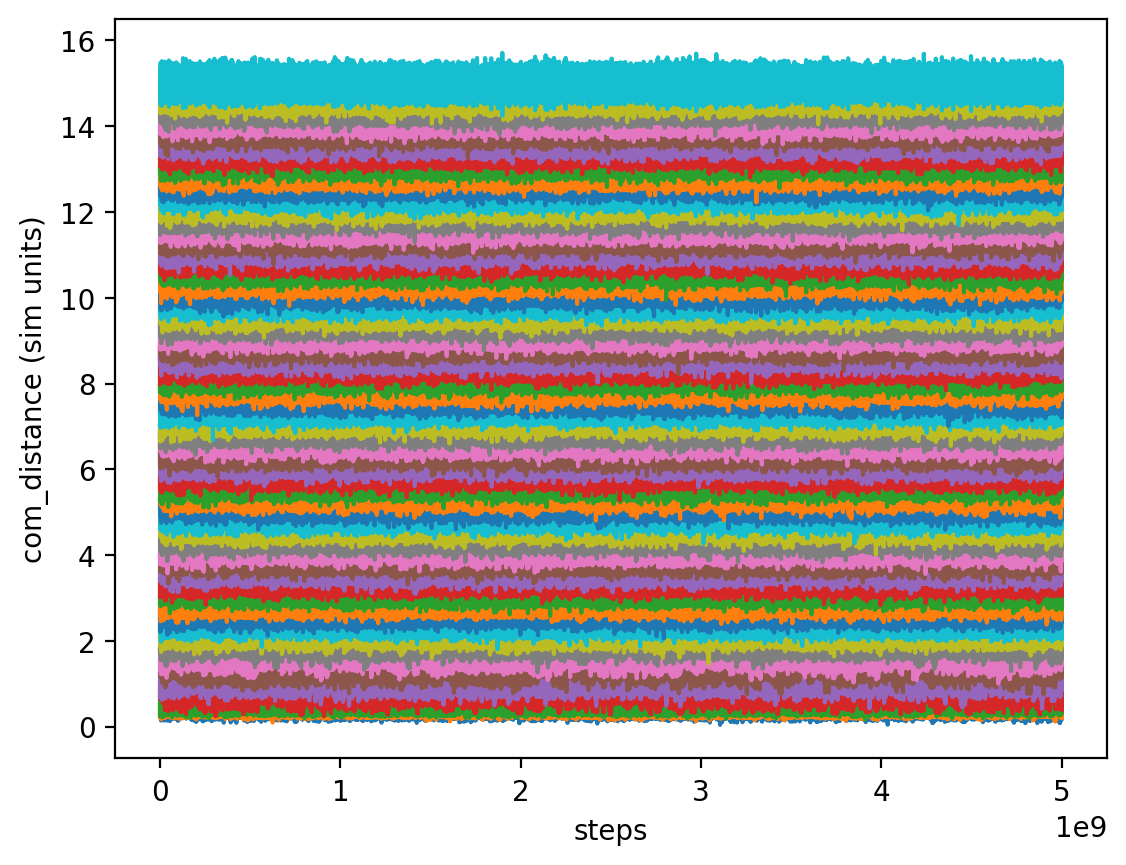

In [9]:
for us in us_list:
    us.com_distance_observable(com_list, ref_list)


for us in us_list:
    plt.figure(dpi=200)
    for idx in range(0,60,1):
        us.analysis.view_observable('prod', idx, observable=us.observables_list[0], sliding_window=False)
    # plt.legend([us.system], fontsize=7)

In [3]:
path = os.path.abspath('/scratch/mlsample/ipy_oxDNA/ipy_oxdna_examples')
systems = ['duplex_melting']

file_dir_list = [f'{path}/{sys}' for sys in systems]
sim_dir_list = [f'{file_dir}/vmmc_melting_replicas/vmmc_melting_rep' for sys, file_dir in zip(systems, file_dir_list)]

n_replicas = 40
vmmc_replica_generator = VmmcReplicas()

vmmc_replica_generator.multisystem_replica(
    systems,
    n_replicas,
    file_dir_list,
    sim_dir_list
)
vmmc_sim_list = vmmc_replica_generator.sim_list
queue_of_simulations = vmmc_replica_generator.queue_of_sims

/home/mlsample/.local/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/mlsample/.local/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


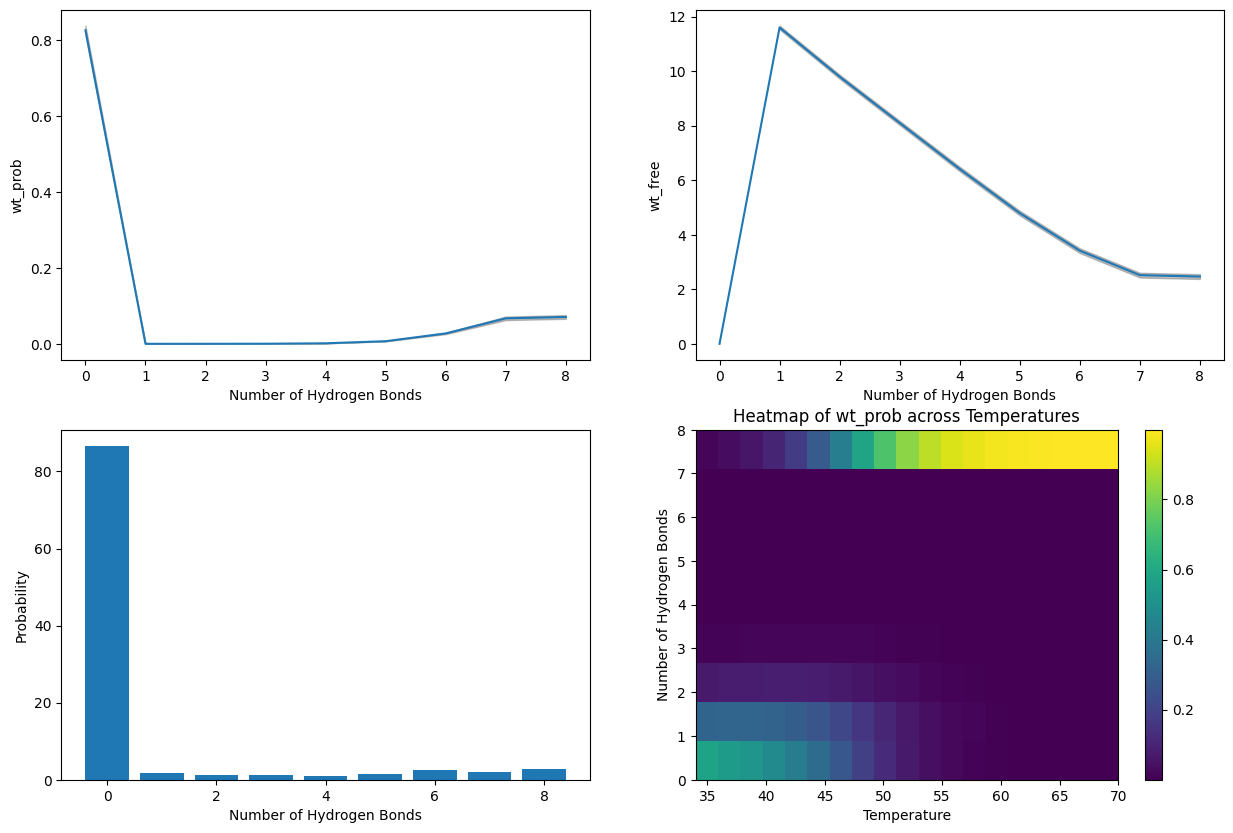

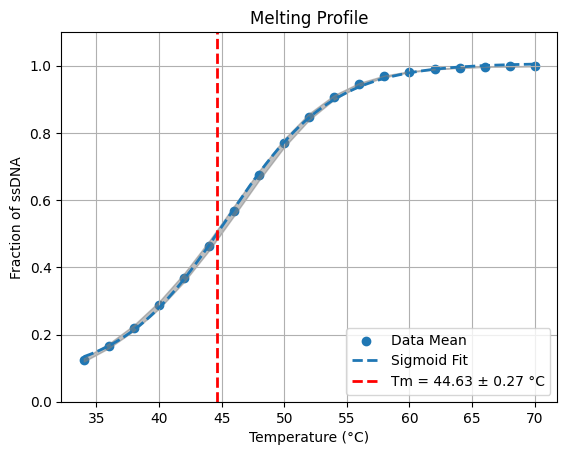

In [4]:
vmmc_replica_generator.statistical_analysis_and_plot()

No non-zero minimum value found.
No non-zero minimum value found.
No non-zero minimum value found.
No non-zero minimum value found.


(-0.1, 8.1)

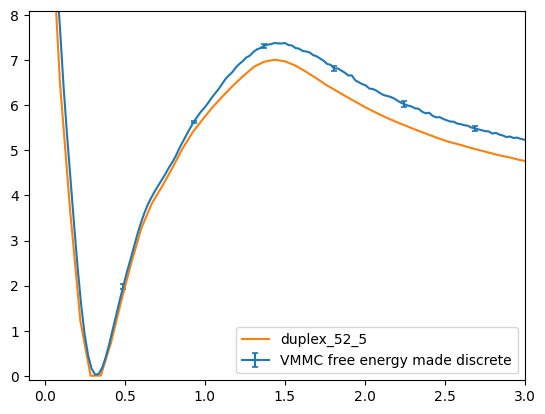

In [5]:
fig, ax = plt.subplots()

vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=1000, errorevery=20,ax=ax)
for us in us_list:
    us.wham.plot_free_energy(ax = ax)
plt.legend()
plt.xlim(-0.1, 3)
plt.ylim(-0.1,8.1)

In [219]:
max_hb = 8
temp_range = np.array([30, 52, 70])
us_list[0].temperature_interpolation(max_hb, temp_range)

In [ ]:
for free in us_list[0].prob_discrete:
    print(free[0])

0.0004021891924218978
0.01620693627913831
0.20484034966142928


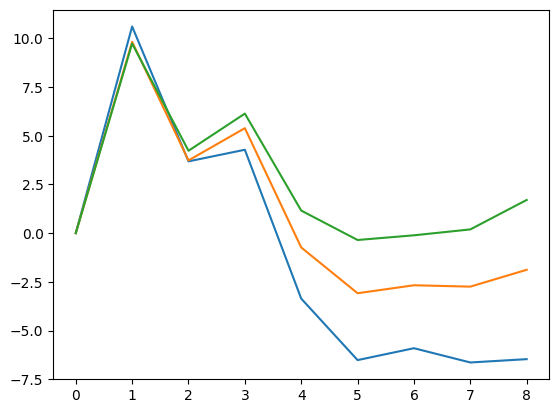

In [ ]:
for idx, free in enumerate(us_list[0].free_energy_discrete):
    plt.plot(range(9), free, label=f'{temp_range[idx]}C')

In [248]:
np.array(us_list[1].energy_bias_per_window_per_temperature).shape

(60, 3, 500001)

In [250]:
vmmc_replica_generator.sim_list[0].analysis.calculate_sampling_and_probabilities()

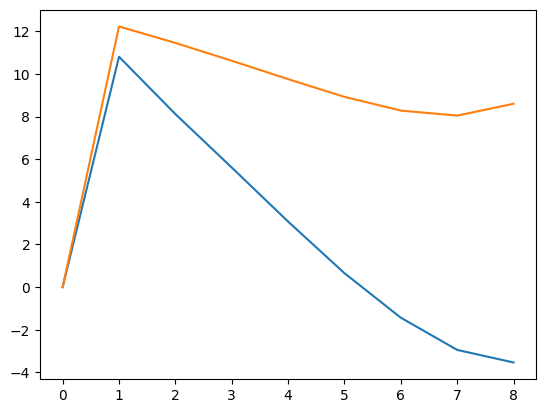

In [255]:
plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'] - vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'][0])

plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_70.0C_free']- vmmc_replica_generator.sim_list[0].statistics['wt_occ_70.0C_free'][0])

plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'])

plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'])

In [242]:
a = us_list[1].A_i
t1 = us_list[1].log_p_i_h
t2 = np.transpose(t1, (1,0,2))

t3 = np.empty((3,60,9))

for temp_idx,temp in enumerate(t2):
    
    for win_idx, (window, a1) in enumerate(zip(temp, a)):
        
        t3[temp_idx, win_idx] = window + window
        
t4 = np.transpose(t3, (0,2,1))

t5 = [[logsumexp(hb) for hb in win] for win in t4]

np.exp(t5)

array([[5.03378713e+01, 3.92089754e-06, 7.97720665e-02, 1.64994560e-02,
        7.14185758e-01, 6.95824270e-01, 1.03570261e-01, 9.70261174e-01,
        1.47907006e+00],
       [5.11742051e+01, 1.18165529e-05, 3.61567598e-02, 3.30543237e-03,
        1.10488020e+00, 2.80031766e-01, 1.41466382e-01, 9.80391166e-01,
        9.51376831e-01],
       [5.21112380e+01, 2.34626574e-05, 3.98072823e-03, 1.24801522e-03,
        1.20169492e+00, 1.78682095e-01, 2.31493590e-01, 9.39569735e-01,
        5.81776151e-01]])

In [188]:
us_list[1].free_energy_discrete

array([-0.80879489, 11.02427574,  7.72089498,  7.41997908,  5.44915207,
        3.96155043,  2.39473149,  1.27473653,  1.02247063], dtype=float128)

In [8]:
weighted_windows = np.empty((100,3,9))
for idx, (a, p_i) in enumerate(zip(us_list[0].A_i, us_list[0].log_p_i_h)):
    weighted_windows[idx] = np.array(a) + p_i

In [48]:
temp = np.array(us_list[0].log_p_i_h)
t2 = np.reshape(temp, (3, 100, 9))
t3 = [[p_i + a for p_i, a in zip(t2_star, us_list[0].A_i)] for t2_star in t2]
t4 = np.reshape(t3, (3, 9, 100))
t5 = np.array([[np.exp(logsumexp(f)) for f in f_star] for f_star in t4])
t5

array([[0.22794897, 0.00605886, 0.02005308, 0.04252974, 0.06728618,
        0.09831671, 0.13718405, 0.18256793, 0.21805448],
       [0.22810718, 0.00709023, 0.02143819, 0.04072429, 0.06651688,
        0.09831675, 0.13718411, 0.18256783, 0.21805453],
       [0.22810718, 0.00709024, 0.02143807, 0.0407244 , 0.06651694,
        0.09831655, 0.13718424, 0.1825679 , 0.21805448]], dtype=float128)

In [17]:
temps = {temp:[[] for _ in range(max_hb+1)] for temp in temp_range}

for win_idx,window in enumerate(weighted_windows):

    for temp_idx, temp_list in enumerate(window):

        for hb_idx,hist_part in enumerate(temp_list):
        
            temps[temp_range[temp_idx]][hb_idx].append(hist_part)

            

In [27]:
final = {}
for temp, hb_list in temps.items():
    final[temp] = []
    for hbs in hb_list:
        final[temp].append(np.exp(logsumexp(hbs)))

In [57]:
us_list[0].log_p_i_h[0] + np.array(us_list[0].A_i[0])

array([[-22.55542197, -22.55542197, -17.07059311, -13.87382889,
        -10.76111844,  -8.32324616,  -6.20102973,  -4.6842221 ,
         -4.11412884],
       [-15.29970663, -15.29970663, -14.13245596, -11.9372655 ,
         -9.26390594,  -7.31524785,  -5.64254313,  -4.53601651,
         -4.35482013],
       [-10.21222634, -10.21222634, -12.15140723, -10.512973  ,
         -8.18982861,  -6.59355027,  -5.26230507,  -4.49214318,
         -4.63152121]], dtype=float128)

In [ ]:
t1 = np.array(us_list[0].log_p_i_h)
t1
# t2 = np.reshape(t1, (t1.shape[1], t1.shape[0], t1.shape[2]))

# t3 = np.array([[p_i + a for p_i,a in zip(p_i_win, us_list[0].A_i)] for p_i_win in t2])
# t4 = np.reshape(t3, (t3.shape[0], t3.shape[2], t2.shape[1]))

# t5 = np.array([[logsumexp(hb) for hb in hb_list] for hb_list in t4])
# np.exp(t5)

In [25]:
temp = np.array(us_list[0].windowed_log_prob_discrete)
t1 = np.reshape(temp, (len(temp_range), us_list[0].n_windows, max_hb+1))

temps = {temperature:None for temperature in temp_range}

for temp_idx, tem in enumerate(t1):
    temps[temp_range[temp_idx]] = [logsumexp(f) for f in tem.T]
temps
    # np.sum(np.exp(temps[40]))
# t_1 = temp.T
# t_2 = np.array([[-logsumexp(hb) for hb in win_hb] for win_hb in t_1]).T
# t_3 = [free - free[0] for free in t_2]
# t_4 = [np.exp(-free) for free in t_2]
# t_4
# for temp_idx, free in enumerate(t_3):
#     plt.plot(range(9), free, label=f'{temp_range[temp_idx]}')

{30: [-3.3293621145990252546,
  -7.4411927354452363052,
  -8.396254222843848175,
  -6.8609575887518177715,
  -5.521078873151503244,
  -3.9820594354996395113,
  -2.2953839691241553066,
  -1.0899123287015801691,
  -0.78873574779745001147],
 40: [-1.0663332027463487362,
  -13.526061792242277735,
  -14.648403773854555652,
  -16.413184749629508451,
  -16.413184749629508451,
  -16.413184749629508451,
  -16.413184749629508451,
  -16.413184749629508451,
  -16.413184749629508451],
 50: [-0.067493716754040451646,
  -14.613374301625625874,
  -14.613374301625625874,
  -14.613374301625625874,
  -14.613374301625625874,
  -14.613374301625625874,
  -14.613374301625625874,
  -14.613374301625625874,
  -14.613374301625625874],
 60: [0.5705667624265872589,
  -13.592009545977539353,
  -13.592009545977539353,
  -13.592009545977539353,
  -13.592009545977539353,
  -13.592009545977539353,
  -13.592009545977539353,
  -13.592009545977539353,
  -13.592009545977539353]}

In [119]:
wham_dir = os.path.abspath('/scratch/mlsample/ipy_oxDNA/wham/wham')
n_bins = '200'
tol = '1e-12'
n_boot = '0'
for us in us_list:
    us.wham_run(wham_dir, xmin, xmax, 10, n_bins, tol, n_boot)

Running WHAM analysis...
WHAM analysis completed


In [ ]:
wham_dir = os.path.abspath('/scratch/mlsample/ipy_oxDNA/wham/wham')
n_bins = '200'
tol = '1e-12'
n_boot = '0'
for us in us_list:
    us.wham_run(wham_dir, xmin, xmax, 10, n_bins, tol, n_boot)

In [181]:
max_hb = 8
us_list[0].continuous_to_discrete_unbiasing(max_hb)
# us_list[1].continuous_to_discrete_unbiasing(max_hb)

In [63]:
us_list[1].free_energy_discrete[0] = us_list[1].free_energy_discrete[0] - 0.64703
us_list[1].free_energy_discrete = us_list[1].free_energy_discrete + 0.64703

In [245]:
us_list[0].volume_correction

0.5081541600408179549

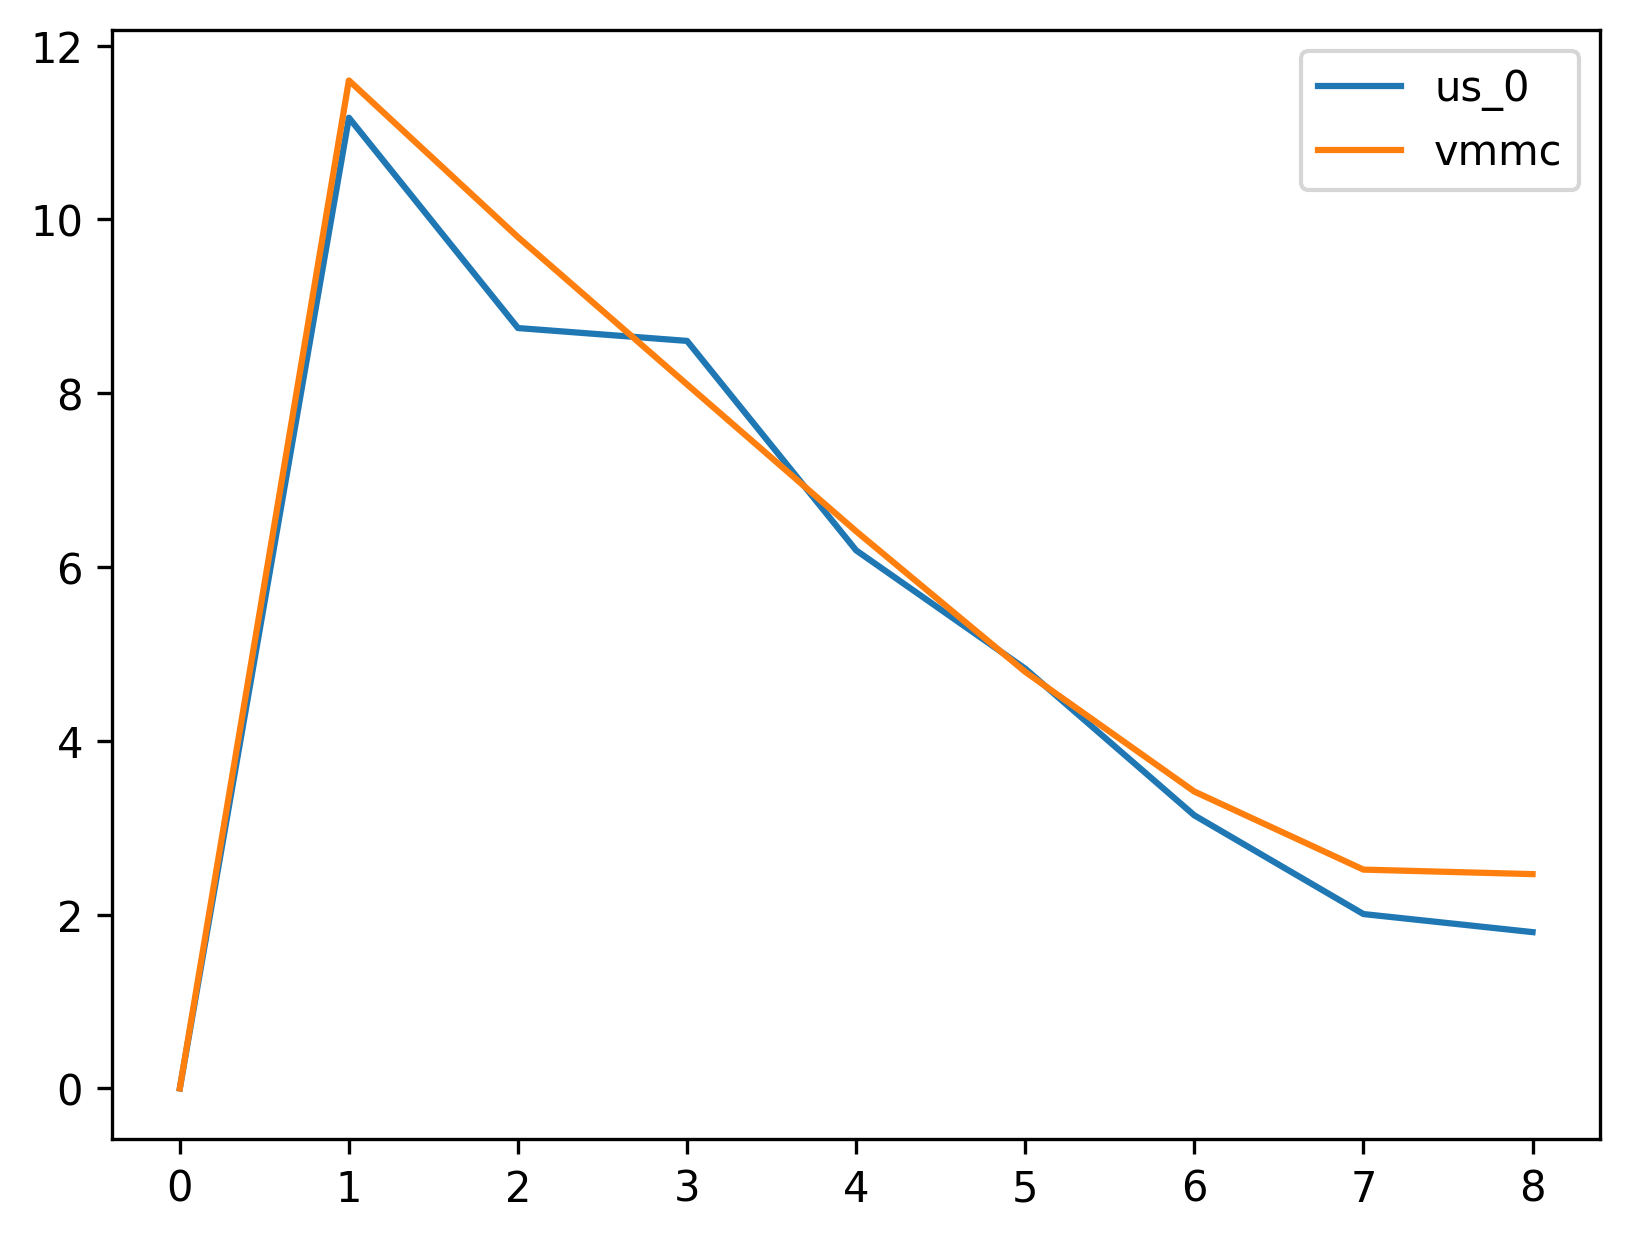

In [182]:
fig, ax = plt.subplots(dpi=300)

# ax.plot(range(9), us_list[1].free_energy_discrete, label='us_1')

ax.plot(range(9), us_list[0].free_energy_discrete, label='us_0')
ax.plot(range(9), vmmc_replica_generator.wt_free_mean, label='vmmc')
plt.legend()

In [ ]:
path = os.path.abspath('/scratch/mlsample/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/')

system_name = 'multi_system_runs'

systems = ['duplex_25', 'duplex_30', 'duplex_35', 'duplex_40', 'duplex_45', 'duplex_50', 'duplex_55', 'duplex_60', 'duplex_65', 'duplex_70']
temperature_list = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]


com_list = '8,9,10,11,12,13,14,15'
ref_list = '0,1,2,3,4,5,6,7'
xmin = 0
xmax = 15
n_windows = 100

stiff = 0.4

equlibration_parameters_list = [{'backend':'CPU','steps':'5e7','print_energy_every': '4e7',
                           'print_conf_interval':'4e7', "CUDA_list": "no",
                           'use_edge': 'false', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                           'T':f'{temp}C'} for temp in temperature_list]

production_parameters_list = [{'backend':'CPU','steps':'1e9','print_energy_every': '1e8',
                        'print_conf_interval':'1e8', "CUDA_list": "no",
                        'use_edge': 'false', 'refresh_vel': '1',
                        'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                        'T':f'{temp}C'} for temp in temperature_list]

us_list = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]

simulation_manager = SimulationManager()

In [ ]:
wham_dir = os.path.abspath('/scratch/mlsample/ipy_oxDNA/wham/wham')
n_bins = '200'
tol = '1e-12'
n_boot = '0'

xmin = 0
xmax = 15
n_windows = 100
stiff = 0.4
for us in us_list:
    us.spawn_wham_run(wham_dir, xmin, xmax, stiff, n_bins, tol, n_boot, join=False)

In [ ]:
for us in us_list:
    us.free['Free'] -= us.free['Free'][4] 

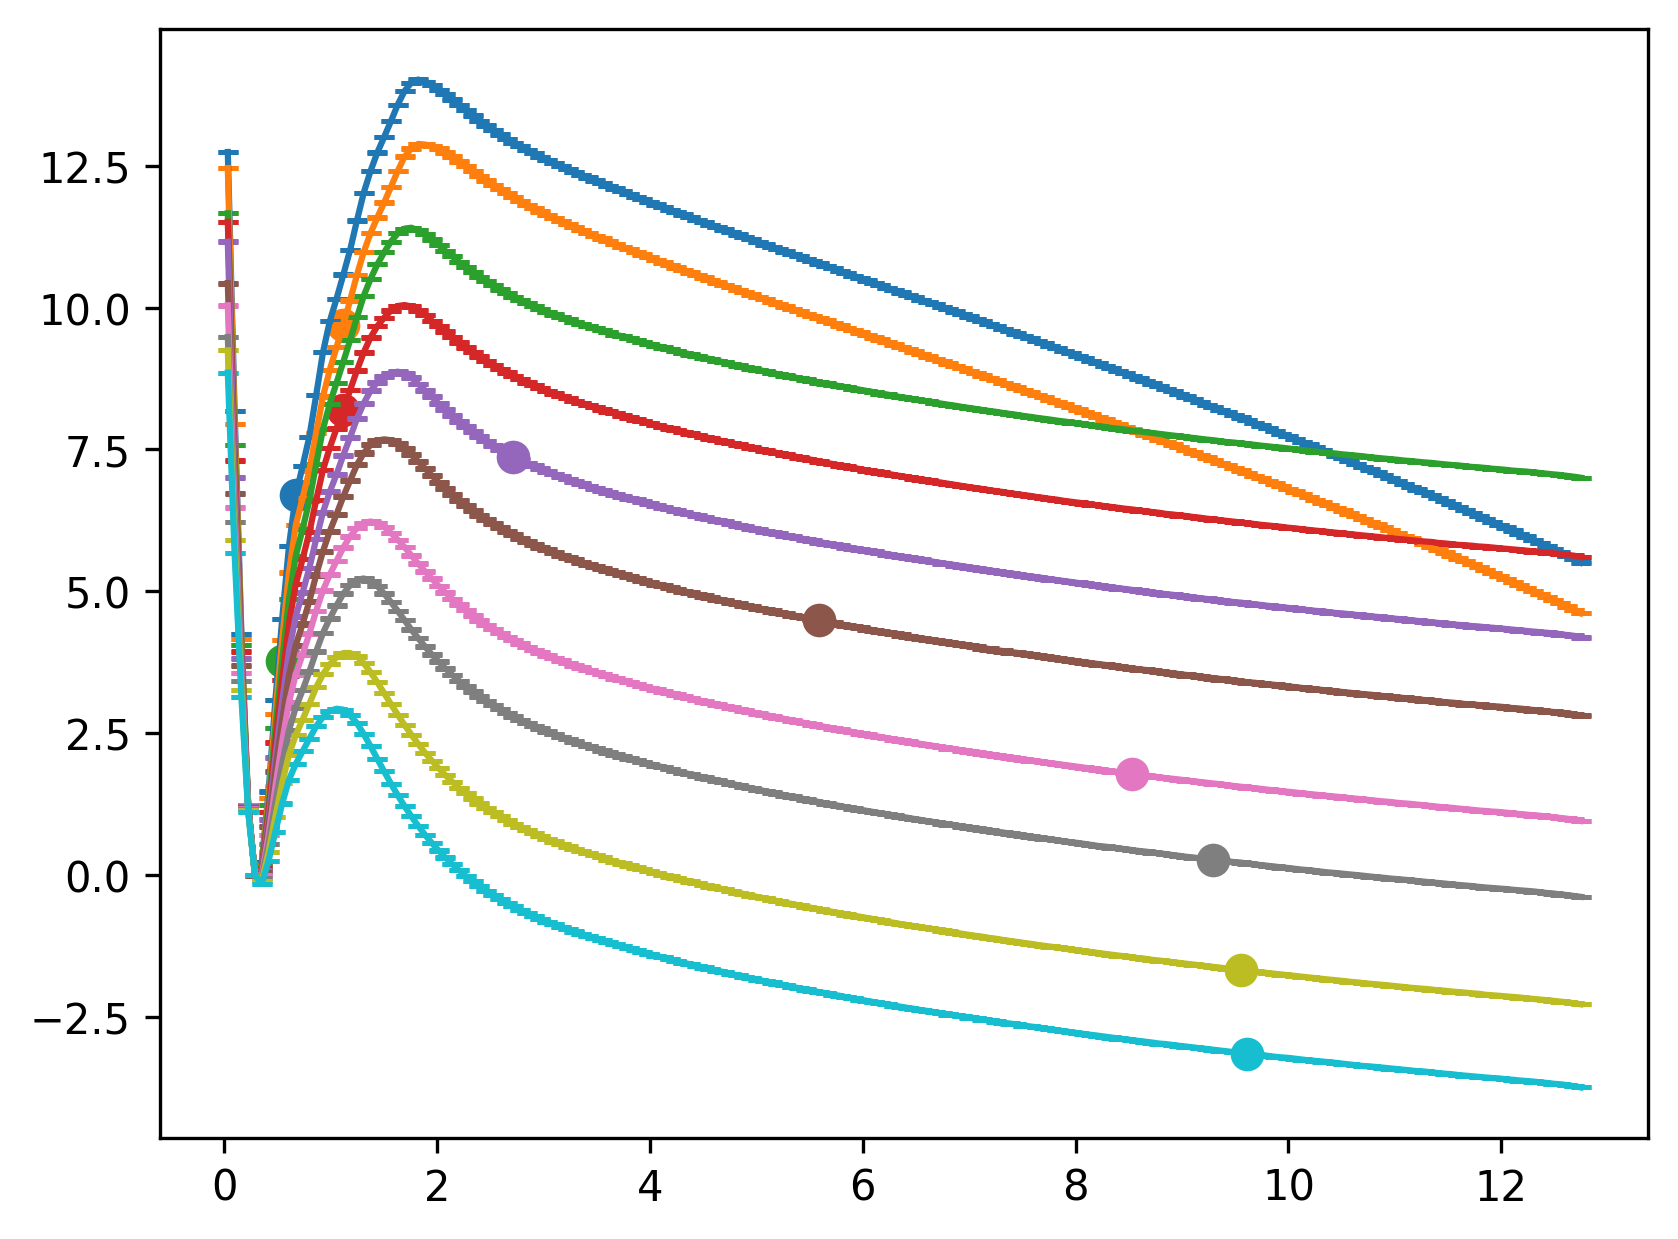

In [124]:
fig, ax = plt.subplots(dpi=300)

for us in us_list:
    us.wham.plot_free_energy(ax=ax, label=us.system)

In [181]:
max_hb = 8
for us in us_list:
    us.continuous_to_discrete_unbiasing(max_hb)

In [179]:
bound = []
for us in us_list:
    bound.append((us.prob_discrete[0]))

bound

[0.046591113203769966746,
 0.105500462117144573,
 0.45206423299709345656,
 0.7520536002549230574,
 0.92636312026265805596,
 0.9750550487967221464,
 0.9976445141341746598,
 0.999877481687682005,
 0.99996457883247635357,
 1.0]

In [180]:
def sigmoid(self, x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

temps = np.linspace(25,70,10)
p0 = [max(bound), np.median(temps), 1, min(bound), 1]  # initial guesses for L, x0, k, b
popt, _ = curve_fit(sigmoid, temps, bound, p0, method='dogbox')
# Generate fitted data
x_fit = np.linspace(min(temps), max(temps), 500)
y_fit = sigmoid(x_fit, *popt)


idx = np.argmin(np.abs(y_fit - 0.5))
Tm = x_fit[idx]

y_fit

0.725511415238163

In [177]:
y_fit

0.725511415238163

ValueError: x and y must have same first dimension, but have shapes (500,) and (1,)

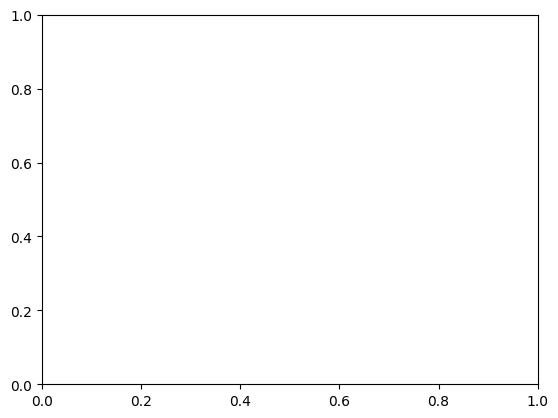

In [176]:
plt.plot(x_fit, y_fit, label='fit')

In [133]:
plt.figure(figsize=(10, 6))
plt.scatter(temps, self.inverted_finfs, marker='o', label=f'{label}Data')
plt.plot(self.x_fit, self.y_fit, linestyle='--', linewidth=2, label=f'{label}Sigmoid Fit')

# Add a vertical line at the melting temperature
plt.axvline(x=self.sim.Tm, color='r', linestyle='--', linewidth=2, label=f'{label}Tm = {self.sim.Tm:.2f} °C')

plt.xlabel('Temperature (°C)')
plt.ylabel('Fraction of ssDNA')
plt.title(f'Melting Profile')

# Set y-axis limits
plt.ylim(0, 1.1)

plt.legend()
plt.grid(True)

AttributeError: 'MeltingUmbrellaSampling' object has no attribute 'free_energy_discrete'

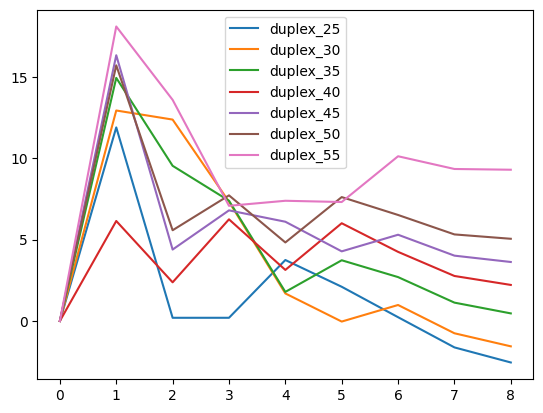

In [140]:
for us in us_list[:-3]:
    plt.plot(range(9), us.free_energy_discrete, label=us.system)
plt.legend()

In [141]:
for us in us_list:
    us.calculate_melting_temperature()

/scratch/mlsample/ipy_oxDNA/src/umbrella_sampling.py:810: RuntimeWarning: divide by zero encountered in scalar divide
  ax.set_xlabel('Number of Hydrogen Bonds')
/scratch/mlsample/ipy_oxDNA/src/umbrella_sampling.py:810: RuntimeWarning: invalid value encountered in scalar subtract
  ax.set_xlabel('Number of Hydrogen Bonds')


In [154]:
for us in us_list:
    print(us.inverted_finf)

0.197973193095128306
0.289483716233426299
0.5850817239589330083
0.7927854185558869842
0.93108790361858780006
0.975647725882325699
0.9976500412637172993
0.99987749700686068266
0.99996458025452295004
nan


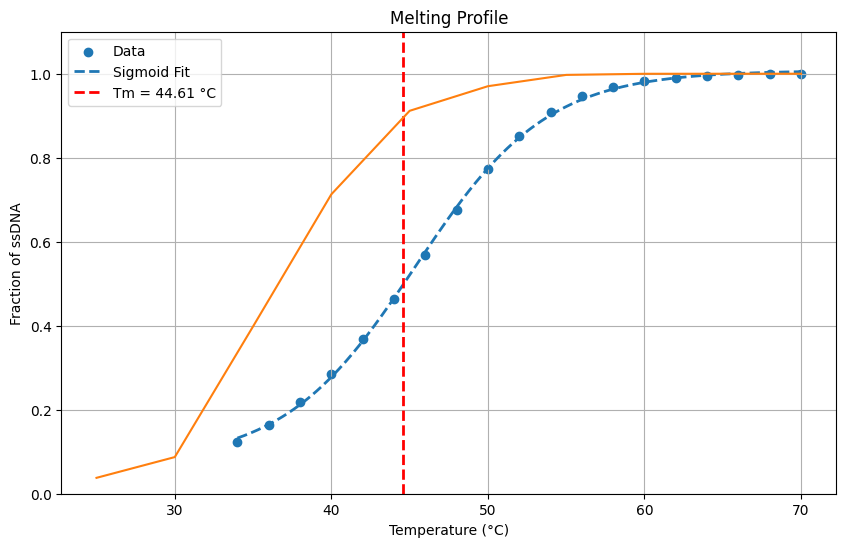

In [160]:
temps = np.linspace(25,70,10)
vmmc_replica_generator.sim_list[0].analysis.plot_melting_profiles()
plt.plot(temps,bound)

In [ ]:
for us in us_list:
    us.calculate_melting_temperature_using_vmmc()

In [41]:
inverted_finfs = []
temperatures = []
for us in us_list:
    inverted_finfs.append(1 - us.vmmc_sim.analysis.finfs[0])
    temperatures.append(float((us.system.split('_')[-1])))
# del inverted_finfs[2]
# del temperatures[2]
inverted_finfs

[0.040445674159148015,
 0.24474776458088066,
 0.8527707387393986,
 0.29098219022476146,
 0.5848513264788701,
 0.7420957783101831,
 0.9079703729455932,
 0.9760818911323383,
 0.9935216693156264,
 0.9993579353634914]

In [39]:
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

from scipy.optimize import curve_fit

p0 = [max(inverted_finfs), np.median(temperatures), 1, min(inverted_finfs)]  # initial guesses for L, x0, k, b
popt, _ = curve_fit(sigmoid, temperatures, inverted_finfs, p0, method='dogbox')

x_fit = np.linspace(min(temperatures), max(temperatures), 500)
y_fit = sigmoid(x_fit, *popt)

idx = np.argmin(np.abs(y_fit - 0.5))
Tm = x_fit[idx]

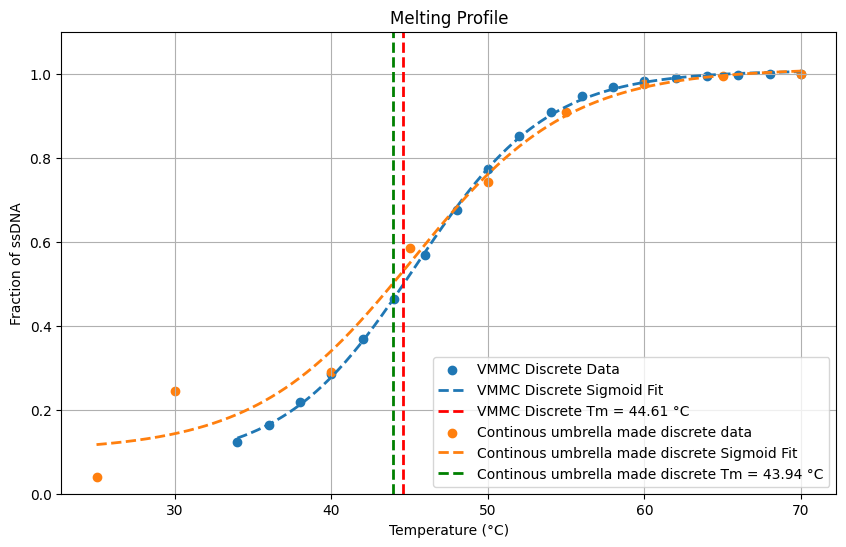

In [83]:
# Plotting
# plt.figure(figsize=(10, 6))
vmmc_sim_list[0].analysis.plot_melting_profiles(label='VMMC Discrete ')

plt.scatter(temperatures, inverted_finfs, marker='o', label='Continous umbrella made discrete data')
plt.plot(x_fit, y_fit, linestyle='--', linewidth=2, label='Continous umbrella made discrete Sigmoid Fit')

# Add a vertical line at the melting temperature
plt.axvline(x=Tm, color='green', linestyle='--', linewidth=2, label=f'Continous umbrella made discrete Tm = {Tm:.2f} °C')

plt.xlabel('Temperature (°C)')
plt.ylabel('Fraction of ssDNA')
plt.title(f'Melting Profile')

# Set y-axis limits
plt.ylim(0, 1.1)

plt.legend()
plt.grid(True)
plt.show()
